In [26]:
# install libraries
# !pip install hazm
# !pip install pandas
# !pip install gensim

In [51]:
# libraries
import codecs
import os
import json
import tqdm
import random
from collections import Counter
from nltk import FreqDist
import pandas as pd
import numpy as np
import itertools
from hazm import *
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics

In [28]:
import json

DIRNAME = '../new-dataset-with-category'
data = []
for i in range(1, 31):
    with open(f'{DIRNAME}/namnak-{i}.json', 'r', encoding="utf-8") as f:
        data.extend(json.loads(f.read()))

In [29]:
len(data)

7053

# Fasttext Embedding

In [30]:
import codecs
import json
import numpy as np
from hazm import *
from gensim.models.fasttext import FastText


class FastTextEmbedingModel:
    def __init__(self):
        self.ft_model = FastText.load('../models/_fasttext.model')
        with open('../models/tfidfvectorizer-clustering.pk', 'rb') as fin:
            self.tfidfvectorizer = pickle.load(fin)
        self.idf_dict = {term:idf for term, idf in zip(self.tfidfvectorizer.get_feature_names_out(), self.tfidfvectorizer.idf_)}
        self.normalizer = Normalizer()
        self.lemmatizer = Lemmatizer()
        stopwords = [self.normalizer.normalize(x.strip()) for x in
                     codecs.open('../stopwords/stopwords.txt', 'r', 'utf-8').readlines()]
        custom_stop_words = [self.normalizer.normalize(x.strip()) for x in
                             codecs.open('../stopwords/custom_stopwords.txt', 'r', 'utf-8').readlines()]
        self.total_stop_words = custom_stop_words + stopwords
        
    def get_doc_embeding(self, doc):
        doc_title, doc_text = self.get_text_and_title(doc)
        return self.__get_doc_embeding(doc_title, doc_text)

    def __get_doc_embeding(self, doc_title, doc_text):
        return ((self.get_text_embeding(doc_text) * 19) + self.get_text_embeding(doc_title)) / 20
    
    def get_text_embeding(self, text):
        tokens = [_ for _ in word_tokenize(self.normalizer.normalize(text)) if _ not in self.total_stop_words]
        tokens_after_lemm = [self.lemmatizer.lemmatize(tok) for tok in tokens]
        emb = np.zeros(self.ft_model.wv.vector_size)
        weights = 0
        for token, lem_token in zip(tokens, tokens_after_lemm):
            if lem_token not in self.idf_dict:
                idf = np.log(len(data))
            else:
                idf = self.idf_dict[lem_token]
            emb += (self.ft_model.wv[token] * idf)
            weights += idf
        emb /= weights
        return emb
    
    def get_title_embeding(self, text):
        tokens = [_ for _ in word_tokenize(self.normalizer.normalize(text)) if _ not in self.total_stop_words]
        emb = np.zeros(self.ft_model.wv.vector_size)
        for token in tokens:
            emb += self.ft_model.wv[token]
        emb /= len(tokens)
        return emb
    
    def get_text_and_title(self, doc):
        return doc['title'], doc['abstract'] + " " + " ".join(doc['paragraphs'])

In [31]:
fasttext_embeding_model = FastTextEmbedingModel()

# Prepare Documents Embedding

In [32]:
category_dictionary = {
    'سلامت روان' : 0,
    'دهان و دندان' : 1,
    'پوست و مو' : 2,
    'تغذیه' : 3,
    'سلامت خانواده' : 4,
    'سلامت جنسی' : 5,
    'پیشگیری و بیماریها' : 6
}

In [33]:
doc_num = {_: 0 for _ in category_dictionary.values()}
doc_num_threshold = 350

X_train = list()
Y_test = list()

for i in tqdm.tqdm(range(0, len(data))):
    doc = data[i]
    if doc['category'] in category_dictionary.keys() and doc_num[category_dictionary[doc['category']]] < doc_num_threshold:
        doc_num[category_dictionary[doc['category']]] += 1
        Y_test.append(category_dictionary[doc['category']])
        X_train.append(fasttext_embeding_model.get_doc_embeding(doc))

100%|█████████████████████████████████████████████████████████████████████████████| 7053/7053 [00:24<00:00, 283.14it/s]


In [34]:
len(X_train)

2434

# K-means Clustering

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=50, max_iter=1000, tol=1e-8).fit(X_train)

In [36]:
Y_predicted = kmeans.predict(X_train)

In [37]:
Y_center = [kmeans.cluster_centers_[y] for y in Y_predicted]

In [38]:
for i in range(0,7):
    print(f'cluster{i} : {Y_predicted.tolist().count(i)}')

cluster0 : 365
cluster1 : 503
cluster2 : 231
cluster3 : 325
cluster4 : 215
cluster5 : 316
cluster6 : 479


# Calculate RSS

In [52]:
print(f'RSS = {kmeans.inertia_}')

RSS = 854.8281006528596


# Calculate Davies Bouldian Score

In [53]:
davies_bouldin_score(X_train, Y_predicted)

2.268698673862749

# Calculate Silhouette Score

In [54]:
metrics.silhouette_score(X_train, Y_predicted)

0.10142477546663299

# Purity Score

In [55]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    contin_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contin_matrix, axis=0)) / np.sum(contin_matrix) 

In [56]:
purity_score(Y_test, Y_predicted)

0.5176663927691043

# Plot Clusters Using PCA

In [42]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [43]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1] 

## K-means Clusters

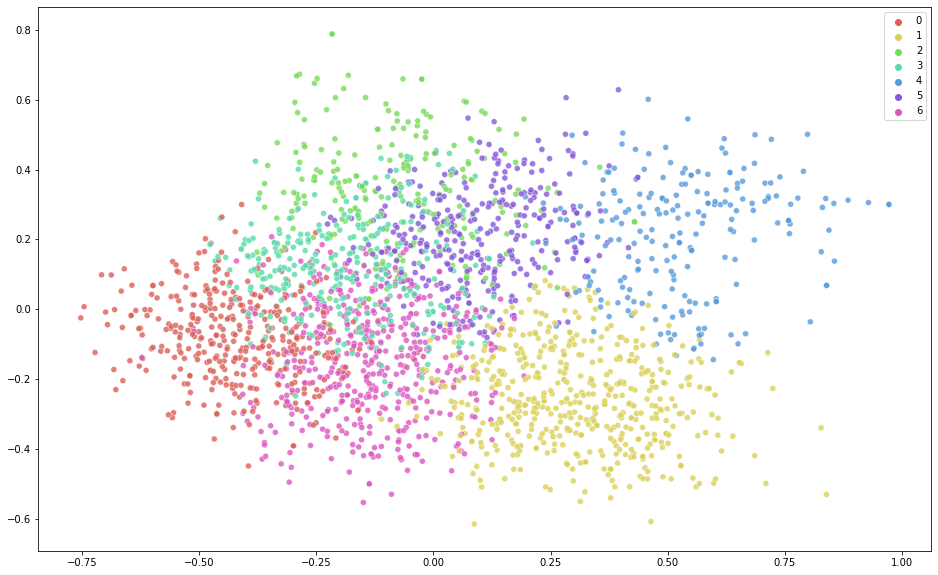

In [44]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)

## Documents True Classes

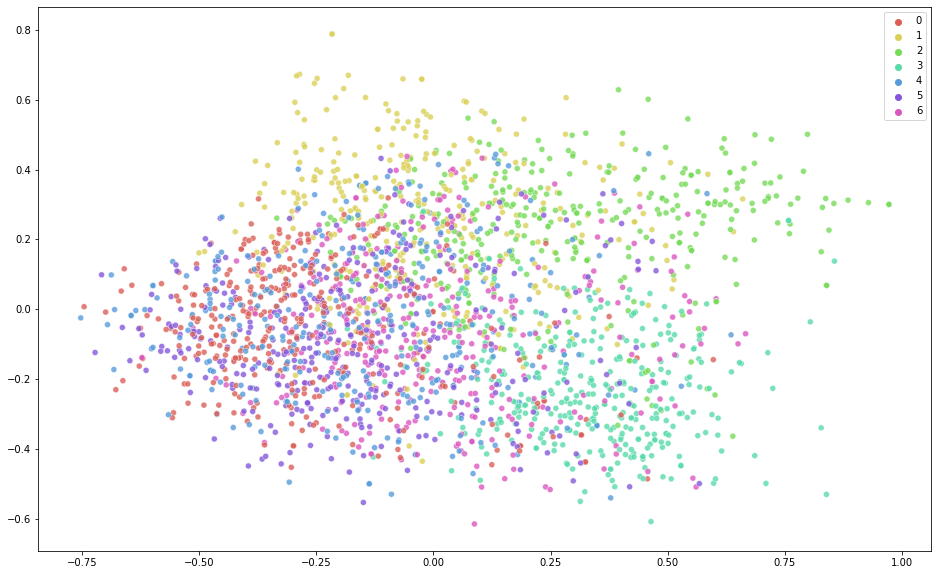

In [45]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)

# Plot Clusters Using TSNE

In [46]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(X_train)

C:\Users\Mahdi\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2434 samples in 0.001s...
[t-SNE] Computed neighbors for 2434 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2434
[t-SNE] Computed conditional probabilities for sample 2000 / 2434
[t-SNE] Computed conditional probabilities for sample 2434 / 2434
[t-SNE] Mean sigma: 0.231398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.669373
[t-SNE] KL divergence after 1000 iterations: 1.405832


In [47]:
tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]

## K-means Clusters

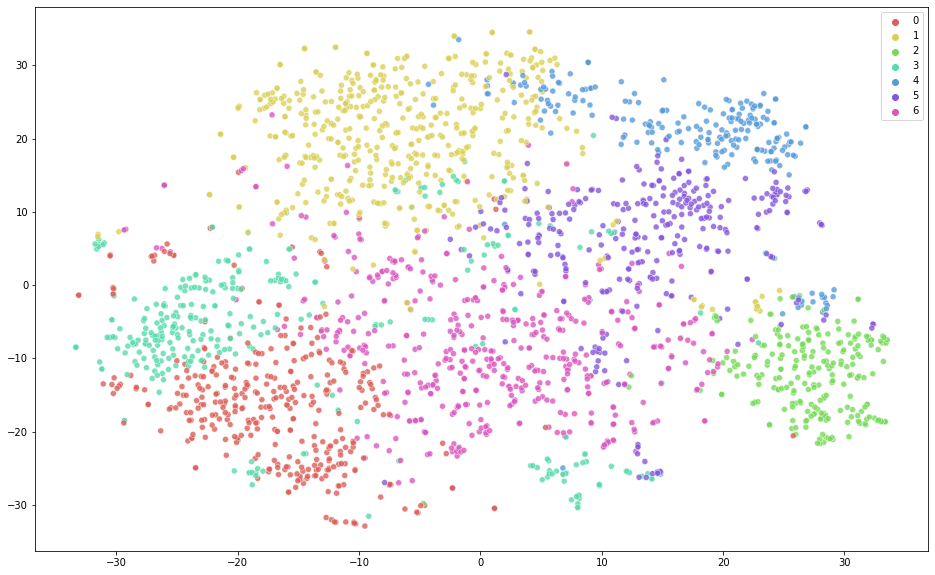

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)

## Documents True Classes

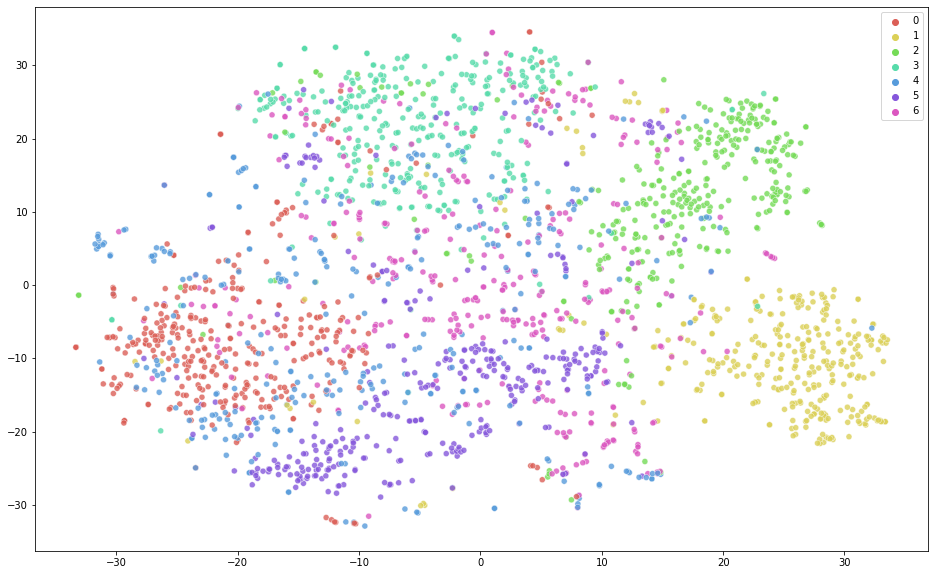

In [49]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)